<IPython.core.display.Javascript object>


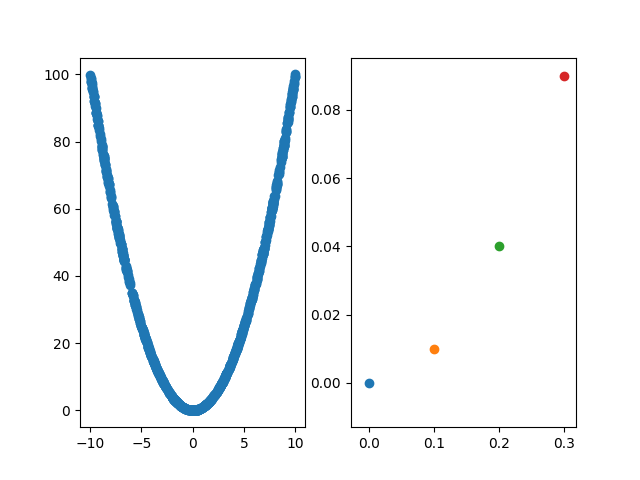

In [10]:
%matplotlib notebook
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np



x = np.random.uniform(-10, 10, 1000)
y = x**2


fig = plt.figure()

ax = fig.add_subplot(1,2,1)
bx = fig.add_subplot(1,2,2)

ax.scatter(x, y)

def animatee(i):
    global ax, x_0
    if i % 20 == 0:
        x_0 = 0
        ax.clear()
        bx.clear()
        ax.scatter(x, y)
        
    bx.scatter(x_0, x_0**2)
    x_0 += 0.1

animation.FuncAnimation(fig, animatee, frames=20, interval=500, repeat=True, repeat_delay=2000)

In [17]:
import math as m

class Vertex:
    """Minimal implementation of a vertex of a 2D dcel"""

    def __init__(self, px, py):
        self.x = px
        self.y = py
        self.hedgelist = []

    def sortincident(self):
        self.hedgelist.sort(key=lambda x : x.angle)
        self.hedgelist.reverse()
        
class Hedge:
    """Minimal implementation of a half-edge of a 2D dcel"""

    def __init__(self,v1,v2):
        #The origin is defined as the vertex it points to
        self.origin = v2
        self.twin = None
        self.face = None
        self.nexthedge = None
        self.angle = hangle(v2.x-v1.x, v2.y-v1.y)
        self.prevhedge = None
        self.length = m.sqrt((v2.x-v1.x)**2 + (v2.y-v1.y)**2)

class Face:
    """Implements a face of a 2D dcel"""

    def __init__(self):
        self.wedge = None
        self.data = None
        self.external = None

    def vertexlist(self):
        h = self.wedge
        pl = [h.origin]
        while(not h.nexthedge is self.wedge):
            h = h.nexthedge
            pl.append(h.origin)
        return pl

    def isinside(self, p):
        """Determines whether a point is inside a face"""

        h = self.wedge
        inside = False
        if lefton(h, p):
            while(not h.nexthedge is self.wedge):
                h = h.nexthedge
                if not lefton(h, p):
                    return False
            return True
        else:
            return False


class DCEL():
    """
    Implements a doubly-connected edge list
    """

    def __init__(self, vl=[], el=[]):
        self.vertices = []
        self.hedges = []
        self.faces = []
        self.el = el
        self.vl = vl


    def build_dcel(self):
        """
        Creates the dcel from the list of vertices and edges
        """

#Step 1: vertex list creation
        for v in self.vl:
            self.vertices.append(Vertex(v[0], v[1]))

#Step 2: hedge list creation. Assignment of twins and 
#vertices
        for e in self.el:
            if e[0] >= 0 and e[1] >= 0:
                h1 = Hedge(self.vertices[e[0]], self.vertices[e[1]])
                h2 = Hedge(self.vertices[e[1]], self.vertices[e[0]])
                h1.twin = h2
                h2.twin = h1
                self.vertices[e[1]].hedgelist.append(h1)
                self.vertices[e[0]].hedgelist.append(h2)
                self.hedges.append(h2)
                self.hedges.append(h1)

        #Step 3: Identification of next and prev hedges
        for v in self.vertices:
            v.sortincident()
            l = len(v.hedgelist)
            if l < 2:
                raise DcelError(
                    "Badly formed dcel: less than two hedges in vertex")
            else:
                for i in range(l-1):
                    v.hedgelist[i].nexthedge = v.hedgelist[i+1].twin
                    v.hedgelist[i+1].prevhedge = v.hedgelist[i]
                v.hedgelist[l-1].nexthedge = v.hedgelist[0].twin
                v.hedgelist[0].prevhedge = v.hedgelist[l-1]

        #Step 4: Face assignment
        provlist = self.hedges[:]
        nf = 0
        nh = len(self.hedges)

        while nh > 0:
            h = provlist.pop()
            nh -= 1
            #We check if the hedge already points to a face
            if h.face == None:
                f = Face()
                nf += 1
                #We link the hedge to the new face
                f.wedge = h
                f.wedge.face = f
                #And we traverse the boundary of the new face
                while (not h.nexthedge is f.wedge):
                    h = h.nexthedge
                    h.face = f
                self.faces.append(f)
        #And finally we have to determine the external face
#         for f in self.faces:
#             f.external = f.area() < 0

    def nfaces(self):
        return len(self.faces)

    def nvertices(self):
        return len(self.vertices)

    def nedges(self):
        return len(self.hedges)/2

def hangle(dx,dy):
    """Determines the angle with respect to the x axis of a segment
    of coordinates dx and dy
    """

    l = m.sqrt(dx*dx + dy*dy)
    if dy > 0:
        return m.acos(dx/l)
    else:
        return 2*m.pi - m.acos(dx/l)

In [18]:
#data structures used in algorithm
from blist import sortedset, sortedlist

#for code decoration
from typing import *

line = List[List[float]]
point = List[float]
determinant = Callable

'determinant function' 
def det(a: point, b: point, c: point) -> int:
    return a[0]*b[1] + a[1]*c[0] + b[0]*c[1] - b[1]*c[0] - a[1]*b[0] - a[0]*c[1]

'a bit tricky intersection checker'
def intersect(a: line, b: line) -> bool:
    #start end points
    a_start, b_start, a_end, b_end = a[0], b[0], a[1], b[1]
    
    return (det(a_start, a_end, b_start) * det(a_start, a_end, b_end) < 0 and 
            det(b_start, b_end, a_start) * det(b_start, b_end, a_end) < 0)

'sturucture that handles events in sweeping algorith'
class Event:
    def __init__(self, position: point, event_type: str, line: line):
        self.position = position
        self.event_type = event_type
        self.line = line
    
    #necessary comparator, the order in T structure
    def __gt__(self, other) -> bool:
        if self.position[0] == other.position[0]:
            if self.event_type == other.event_type:
                return self.position[1] < other.position[1]
            return self.event_type == 'start'
        return self.position[0] < other.position[0]

'structure that handles Line in sweeping algorithm'
class Line:
    def set_class(det: determinant, e: float =1e-8):
        Line.det = det
        Line.e = e
        
    def __init__(self, line: line):
        #standard math line parameters
        self.start = line[0]
        self.end = line[1]
        self.m = (self.start[1]-self.end[1])/(self.start[0]-self.end[0])
        self.b = (self.start[1]-self.m*self.start[0])
    
    'x axis comperator point'
    def set_ordering(x: float):
        Line.ordering_x = x
    
    def get_line(self) -> line:
        return [self.start, self.end]
    
    'necessary comparator, the order in Q structure'
    def __eq__(self, other) -> bool:
        return self.start == other.start and self.end == other.end
    
    def __gt__(self, other) -> bool:
        x = Line.ordering_x
        return self.m*x+self.b > other.m*x+other.b
    
    def __hash__(self):
        return hash(self.start) + hash(self.end)
    
'create event from intersection of two lines'
def get_Event_from_intersection(first: Line, second: Line) -> Event:
    #compute intersection point
    x = (second.b - first.b)/(first.m - second.m)
    intersection_point = (x,first.m*x+first.b)
    #create event
    return Event(intersection_point, 'cross', [first,second])

'check if two lines intersect'
def check_intersection(first: Line, second: Line, T: sortedlist, Q: sortedset) -> None:    
    if intersect(first.get_line(), second.get_line()):
        #add intersection event to T structure
        T.add(get_Event_from_intersection(first, second))

        
'sweeping algorithm to detect intersection points'
def get_intersections(lines: List[line], e: float =1e-14, det: determinant =det) -> List[point]:
    
    #dict of lines for O(1) eddting at intersection point
    L = dict()
    
    #set line determinant and epsilon for error
    Line.set_class(det,e)
    
    #fill T structure with start and end point events
    T = []
    for line in lines:
        l = Line(line) #convert line to Line structure
        T.append(Event(line[0],'start',l))
        T.append(Event(line[1],'end',l))
        L[l] = 1
    
    T = sortedlist(T) #timeline structure declaration
    Q = sortedset() #broom structure declaration
    
    #order of storing Lines in timeline structure
    Line.set_ordering(T[-1].position[0])
    
    #intersection points set
    intersections = set()
    
    while len(T) > 0:
        
        event = T.pop() #get most left event from x axis 
        
        #start of the Line case
        if event.event_type == 'start':
            
            Line.set_ordering(event.position[0])  #set order of storing Lines in timeline structure
            Q.add(event.line) #add Line to broom structure
            
            #check new possible intersections for line below and above newly added line
            b = Q.index(event.line) 
            b -= 1
            if b>=0 and b < len(Q):                
                check_intersection(Q[b], event.line, T, Q)
            
            b += 2
            if b>=0 and b < len(Q):
                check_intersection(Q[b], event.line, T, Q)
            
            
        #end of Line case
        elif event.event_type == 'end':
            
            #check new possible intersections for line below and above lately deleted line
            k = Q.index(event.line)
            a = k+1
            b = k-1
            if a < len(Q) and b < len(Q) and a>=0 and b>=0:    
                check_intersection(Q[a], Q[b], T, Q)
                
            Q.discard(event.line) #delete line from broom structure            
            
        #intersection of two Lines case     
        else:
            #do not handle event that already occured 
            if event.position in intersections:
                continue
            
            #delete lines from structure
            L[event.line[0]] = 0
            L[event.line[1]] = 0
            #add four new lines to structure
            L[Line([event.line[0].get_line()[0], event.position])] = 1
            L[Line([event.position, event.line[0].get_line()[1]])] = 1
            L[Line([event.line[1].get_line()[0], event.position])] = 1
            L[Line([event.position, event.line[1].get_line()[1]])] = 1
            
            
            intersections.add(event.position) #add point to intersetion set
            
            #change Line ordering in broom set: s, s' = s', s 
            Q.discard(event.line[0])
            Q.discard(event.line[1])
            
            Line.set_ordering(event.position[0])            
            Line.ordering_x += 1e-5
            Q.add(event.line[0])
            Q.add(event.line[1])
              
            #check new possible intersections
            k = Q.index(event.line[0])
            m = Q.index(event.line[1])
            
            if k > m:
                k , m = m , k
                
            if m >= 0 and m+1 < len(Q) and m+1 != k:
                check_intersection(Q[m],Q[m+1],T, Q)
            if k-1 >= 0 and k < len(Q) and k-1 != m:
                check_intersection(Q[k],Q[k-1],T, Q)
                
    return list(intersections), L #convert set() to list()

In [19]:

'Animation of the algorithm'
def overlay_of_subdivision(S1, S2):
        
    #Firstly let's get list of lines from Dcel.el and Dcel.vl lists
    lines = []
    for edge in S1.el:
        v1 = S1.vl[edge[0]]
        v2 = S1.vl[edge[1]]
        lines.append(sorted([v1, v2]))
        
    for edge in S2.el:
        v1 = S2.vl[edge[0]]
        v2 = S2.vl[edge[1]]
        lines.append(sorted([v1, v2]))
    
    
    
    #compute intersection points of lines list
    P, L = get_intersections(lines)
    #P = list of intersetion points
    #L = list of new lines for D structure    
    
    D_vl = S1.vl + S2.vl + P 
    
    #delete possible repetition
    D_vl = list(set(D_vl))
    
    #tmp dict for O(1) access to index of vertex
    vertices = { p : idx for idx, p in enumerate(D_vl) }
        
    #mental disease 
    D_el = [[vertices[x], vertices[y]] for x, y in [x.get_line() for x in L if L[x] == 1]]
    
    #now create DCEL structure for D
    D = DCEL(D_vl, D_el)
    
    #and build all vertices, half-edges and faces
    D.build_dcel()
    
    return D

In [20]:
w = [(1,1), (2,2), (1,3), (0,2), (1,1)]
v = [(x[0] + 2, x[1]) for x in w]
w += v
v = [(x[0] + 1, x[1]) for x in w]
w_e = [[i, i+1] for i in range(len(w)-1) if i != 4]
v_e = [[i, i+1] for i in range(len(v)-1) if i != 4]

# ANIMATION

In [21]:
from time import sleep

def animate_intersection(i):
    
    global ax, T, Q, intersections
        
    if i == 0:
    
        e = 1e-14
        det = determinant
        #dict of lines for O(1) eddting at intersection point
        L = dict()

        #set line determinant and epsilon for error
        Line.set_class(det,e)

        #fill T structure with start and end point events
        T = []
        for line in lines:
            l = Line(line) #convert line to Line structure
            T.append(Event(line[0],'start',l))
            T.append(Event(line[1],'end',l))
            L[l] = 1

        T = sortedlist(T) #timeline structure declaration
        Q = sortedset() #broom structure declaration

        #order of storing Lines in timeline structure
        Line.set_ordering(T[-1].position[0])

        #intersection points set
        intersections = set()


    if len(T) > 0:
        event = T.pop() #get most left event from x axis 


        #start of the Line case
        if event.event_type == 'start':
            
            ax.scatter(event.position[0], event.position[1], color='blue')
            fig.show()
            
            li = [event.line.start, event.line.end]
            event_x = [x[0] for x in li]
            event_y = [y[1] for y in li]
            ax.plot(event_x, event_y, color='blue')
            fig.show()
            
            Line.set_ordering(event.position[0])  #set order of storing Lines in timeline structure
            Q.add(event.line) #add Line to broom structure

            #check new possible intersections for line below and above newly added line
            b = Q.index(event.line) 
            b -= 1
            if b>=0 and b < len(Q):                
                check_intersection(Q[b], event.line, T, Q)

            b += 2
            if b>=0 and b < len(Q):
                check_intersection(Q[b], event.line, T, Q)


        #end of Line case
        elif event.event_type == 'end':
            
            ax.scatter(event.position[0], event.position[1], color='green')
            fig.show()
            
            li = [event.line.start, event.line.end]
            event_x = [x[0] for x in li]
            event_y = [y[1] for y in li]
            ax.plot(event_x, event_y, color='green', marker='o')
            fig.show()
            
            #check new possible intersections for line below and above lately deleted line
            k = Q.index(event.line)
            a = k+1
            b = k-1
            if a < len(Q) and b < len(Q) and a>=0 and b>=0:    
                check_intersection(Q[a], Q[b], T, Q)

            Q.discard(event.line) #delete line from broom structure            

        #intersection of two Lines case     
        else:
            #do not handle event that already occured 
            if not event.position in intersections:
                
                ax.scatter(event.position[0], event.position[1], color='red')
                fig.show()                
            
                #delete lines from structure
                L[event.line[0]] = 0
                L[event.line[1]] = 0
                #add four new lines to structure
                L[Line([event.line[0].get_line()[0], event.position])] = 1
                L[Line([event.position, event.line[0].get_line()[1]])] = 1
                L[Line([event.line[1].get_line()[0], event.position])] = 1
                L[Line([event.position, event.line[1].get_line()[1]])] = 1


                intersections.add(event.position) #add point to intersetion set

                #change Line ordering in broom set: s, s' = s', s 
                Q.discard(event.line[0])
                Q.discard(event.line[1])

                Line.set_ordering(event.position[0])            
                Line.ordering_x += 1e-5
                Q.add(event.line[0])
                Q.add(event.line[1])

                #check new possible intersections
                k = Q.index(event.line[0])
                m = Q.index(event.line[1])

                if k > m:
                    k , m = m , k

                if m >= 0 and m+1 < len(Q) and m+1 != k:
                    check_intersection(Q[m],Q[m+1],T, Q)
                if k-1 >= 0 and k < len(Q) and k-1 != m:
                    check_intersection(Q[k],Q[k-1],T, Q)
                    


<IPython.core.display.Javascript object>


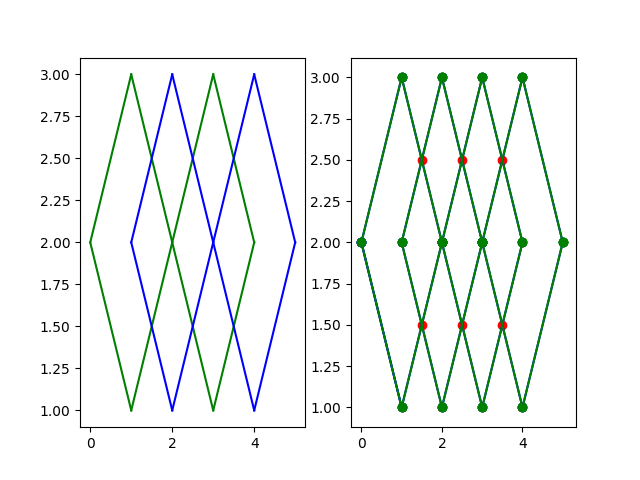

In [23]:
S1 = DCEL(w, w_e)
S2 = DCEL(v, v_e)

eps = 1e-14

vectors = [
    [eps, eps],
    [eps,-eps],
    [-eps,-eps],
    [-eps,eps]
]

def get_direction_of_line(beg, end):
    return (0 if end[0] - beg[0] > 0 else 2) + (1 if end[1] - beg[1] < 0 else 0)

plt.close()

fig = plt.figure()

#Firstly let's get list of lines from Dcel.el and Dcel.vl lists
lines = []
S1_lines = []
for edge in S1.el:
    v1 = S1.vl[edge[0]]
    v2 = S1.vl[edge[1]]
    
    if v1 > v2:
        v1, v2 = v2, v1
    
    vec = vectors[get_direction_of_line(v1, v2)]
    
    v1 = list(v1)
    v2 = list(v2)
    
    v1[0] += vec[0]
    v1[1] += vec[1]
    v2[0] -= vec[0]
    v2[1] -= vec[1]
    
    v1 = tuple(v1)
    v2 = tuple(v2)
    
    S1_lines.append([v1, v2])
    lines.append([v1, v2])

S2_lines = []  
for edge in S2.el:
    v1 = S2.vl[edge[0]]
    v2 = S2.vl[edge[1]]
    
    if v1 > v2:
        v1, v2 = v2, v1

    vec = vectors[get_direction_of_line(v1, v2)]
    
    v1 = list(v1)
    v2 = list(v2)
    
    v1[0] += vec[0]
    v1[1] += vec[1]
    v2[0] -= vec[0]
    v2[1] -= vec[1]
    
    v1 = tuple(v1)
    v2 = tuple(v2)
    
    
    
    S2_lines.append([v1, v2])
    lines.append([v1, v2])

s1_s2 = fig.add_subplot(1,2,1)
    
for line in S1_lines:
    x = [x[0] for x in line]
    y = [y[1] for y in line]
    s1_s2.plot(x, y, color='green')
    
for line in S2_lines:
    x = [x[0] for x in line]
    y = [y[1] for y in line]    
    s1_s2.plot(x, y, color='blue')

ax = fig.add_subplot(1,2,2)


anim = animation.FuncAnimation(fig, animate_intersection, frames=200, interval=500, repeat=False) 

In [16]:
#compute intersection points of lines list
P, L = get_intersections(lines)
#P = list of intersetion points
#L = list of new lines for D structure    

D_vl = S1.vl + S2.vl + P 

#delete possible repetition
D_vl = list(set(D_vl))

#tmp dict for O(1) access to index of vertex
vertices = { p : idx for idx, p in enumerate(D_vl) }

#mental disease 
D_el = [[vertices[x], vertices[y]] for x, y in [x.get_line() for x in L if L[x] == 1]]

#now create DCEL structure for D
D = DCEL(D_vl, D_el)

#and build all vertices, half-edges and faces
D.build_dcel()

NameError: name 'lines' is not defined